# Example plots for gravity and magnetic modelling of ellipsoids 

In [1]:
import functions as fnc
import numpy as np
import sys
import verde as vd
import harmonica as hm
from choclo.point import gravity_u as pointgrav
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.constants import mu_0
from functions import ProlateEllipsoid, ellipsoid_magnetics
np.set_printoptions(threshold=sys.maxsize)
H0 = np.array([55_000, 0.0, 90.0])

In [2]:
# parameters used throughout plots

a, b, c = (5, 3, 1) # triaxial ellipsoid
triaxial_example = fnc.TriaxialEllipsoid(a, b, c, yaw = 0, pitch = 0, roll = 0,  centre = (0, 0, 0))
triaxial_example2 = fnc.TriaxialEllipsoid(a, b, c, yaw = 30, pitch = 60, roll = 45, centre = (7, 7, 0))

# define observation points (2D grid) at surface height (z axis, 'Upward') = 5
coordinates = vd.grid_coordinates(region = (-30, 30, -30, 30), spacing = 0.5, extra_coords = 10)


## Interactive ellipsoid

<IPython.core.display.Javascript object>


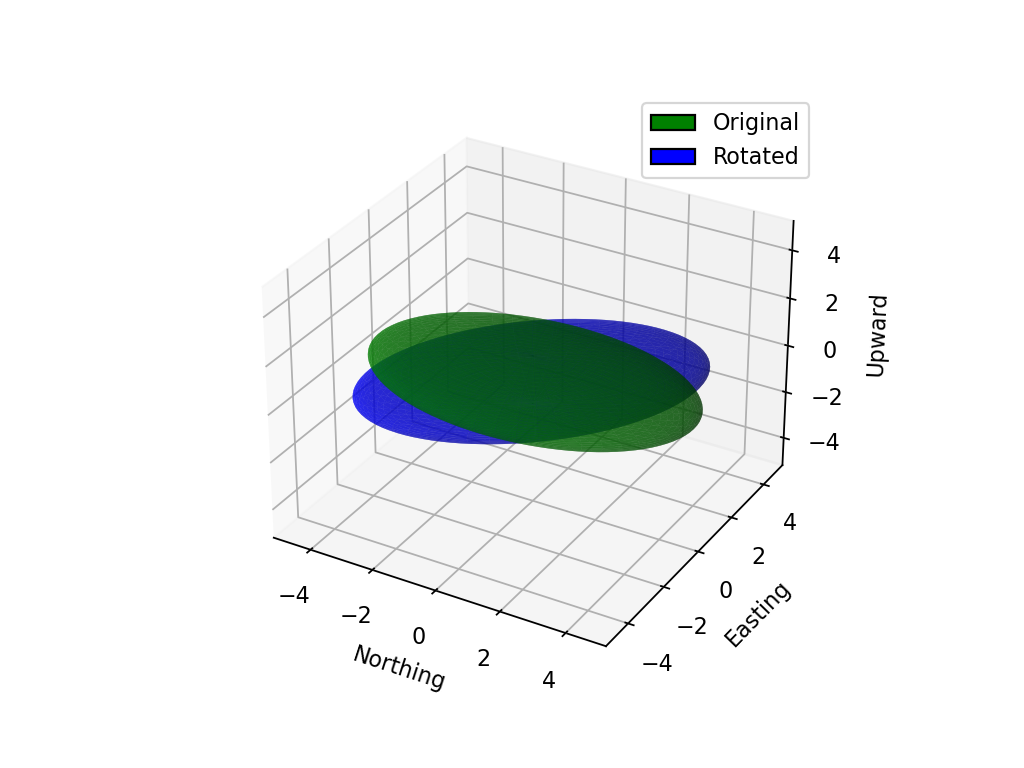

Text(0.5, 0, 'Upward')

In [3]:
%matplotlib notebook

V = fnc._get_v_as_euler(yaw = 45, pitch = 0, roll = 0) # Euler rotation matrix
x1, y1, z1 = fnc._generate_basic_ellipsoid(a, b, c) # creates ellipsoid surface
local_coords = fnc._global_to_local(x1, y1, z1, 0, V) # rotates ellipsoid surface


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

max_radius = max(a, b, c)
for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((-max_radius, max_radius))
    
ax.plot_surface(x1, y1, z1, color='green', alpha=0.6)
ax.plot_surface(local_coords[0], local_coords[1], local_coords[2], color='blue', alpha=0.6)

legend_elements = [
    Patch(facecolor='green', edgecolor='k', label='Original'),
    Patch(facecolor='blue', edgecolor='k', label='Rotated')
]
ax.legend(handles=legend_elements)

ax.set_xlabel('Northing')
ax.set_ylabel('Easting')
ax.set_zlabel('Upward')

### Colormaps of magnetic components - simple example (no rotation, one body)

In [4]:
be, bn, bu = fnc.ellipsoid_magnetics(coordinates, triaxial_example, 0.01, (55_000, 0.0, 90.0))


<IPython.core.display.Javascript object>


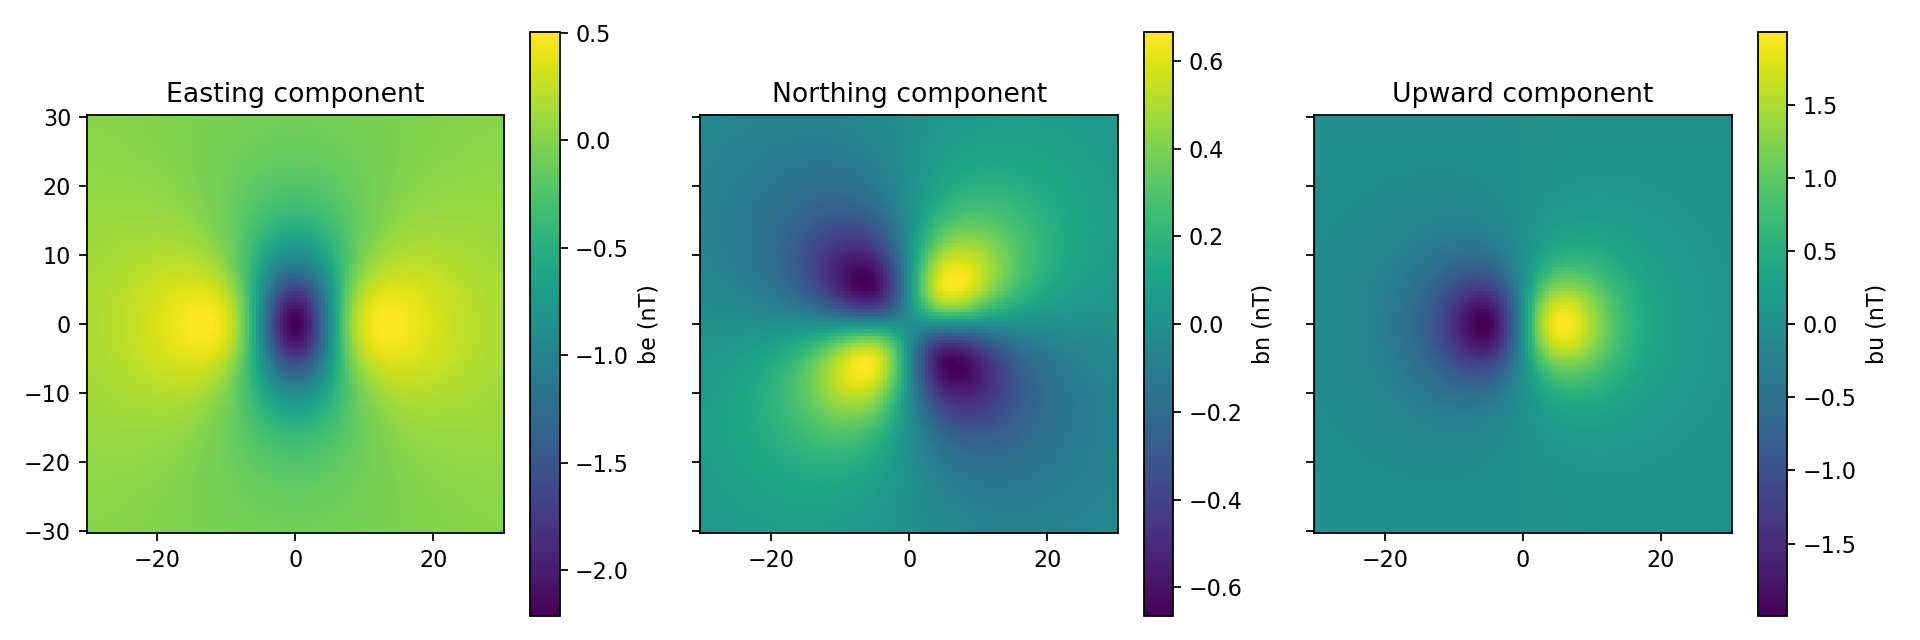

In [5]:
easting, northing = coordinates[:2]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

tmp = ax1.pcolormesh(easting, northing, be)
ax1.set_title("Easting component")
plt.colorbar(tmp, ax=ax1, label="be (nT)")

tmp = ax2.pcolormesh(easting, northing, bn)
ax2.set_title("Northing component")
plt.colorbar(tmp, ax=ax2, label="bn (nT)")

tmp = ax3.pcolormesh(easting, northing, bu)
ax3.set_title("Upward component")
plt.colorbar(tmp, ax=ax3, label="bu (nT)")

for ax in (ax1, ax2, ax3):
    ax.set_aspect("equal")

    
plt.tight_layout()
plt.show()

## 1D section 

Plot of a 1D section over the anomaly:

<IPython.core.display.Javascript object>


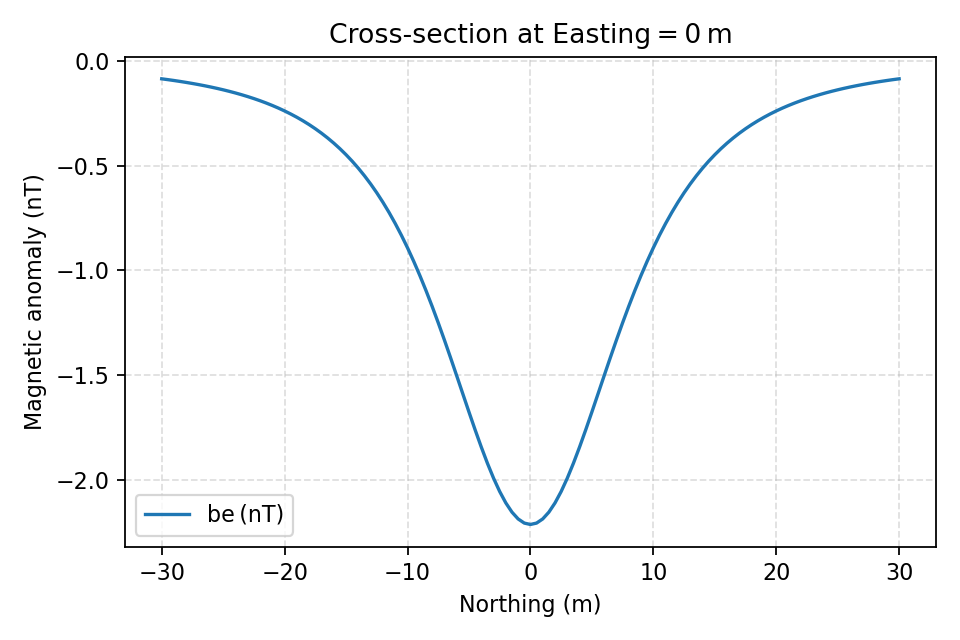

In [6]:

idx_x0 = np.abs(easting[0]).argmin()      

north_line = northing[:, idx_x0]        
be_line   = be[:, idx_x0]

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(north_line, be_line, label="be (nT)")

ax.set_title("Cross‑section at Easting = 0 m")
ax.set_xlabel("Northing (m)")
ax.set_ylabel("Magnetic anomaly (nT)")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()

### Colormaps of magnetic components - multi-body example 

In [7]:
be, bn, bu = fnc.ellipsoid_magnetics(coordinates, [triaxial_example, triaxial_example2], [0.01, 0.01], (55_000, 0.0, 90.0))

<IPython.core.display.Javascript object>


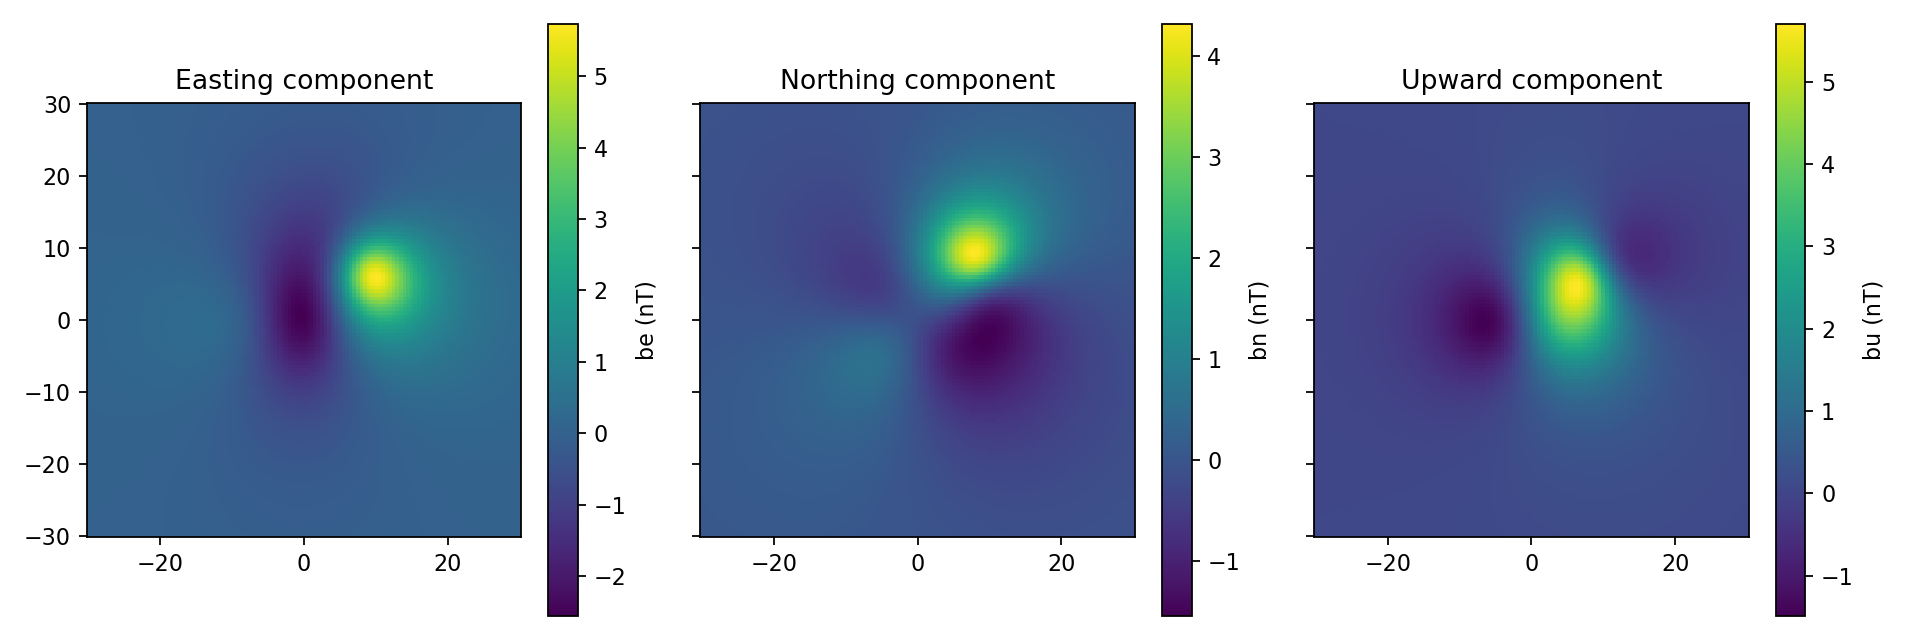

In [8]:
easting, northing = coordinates[:2]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

tmp = ax1.pcolormesh(easting, northing, be)
ax1.set_title("Easting component")
plt.colorbar(tmp, ax=ax1, label="be (nT)")

tmp = ax2.pcolormesh(easting, northing, bn)
ax2.set_title("Northing component")
plt.colorbar(tmp, ax=ax2, label="bn (nT)")

tmp = ax3.pcolormesh(easting, northing, bu)
ax3.set_title("Upward component")
plt.colorbar(tmp, ax=ax3, label="bu (nT)")

for ax in (ax1, ax2, ax3):
    ax.set_aspect("equal")

    
plt.tight_layout()
plt.show()

### 1D section over a multi-body anomaly

<IPython.core.display.Javascript object>


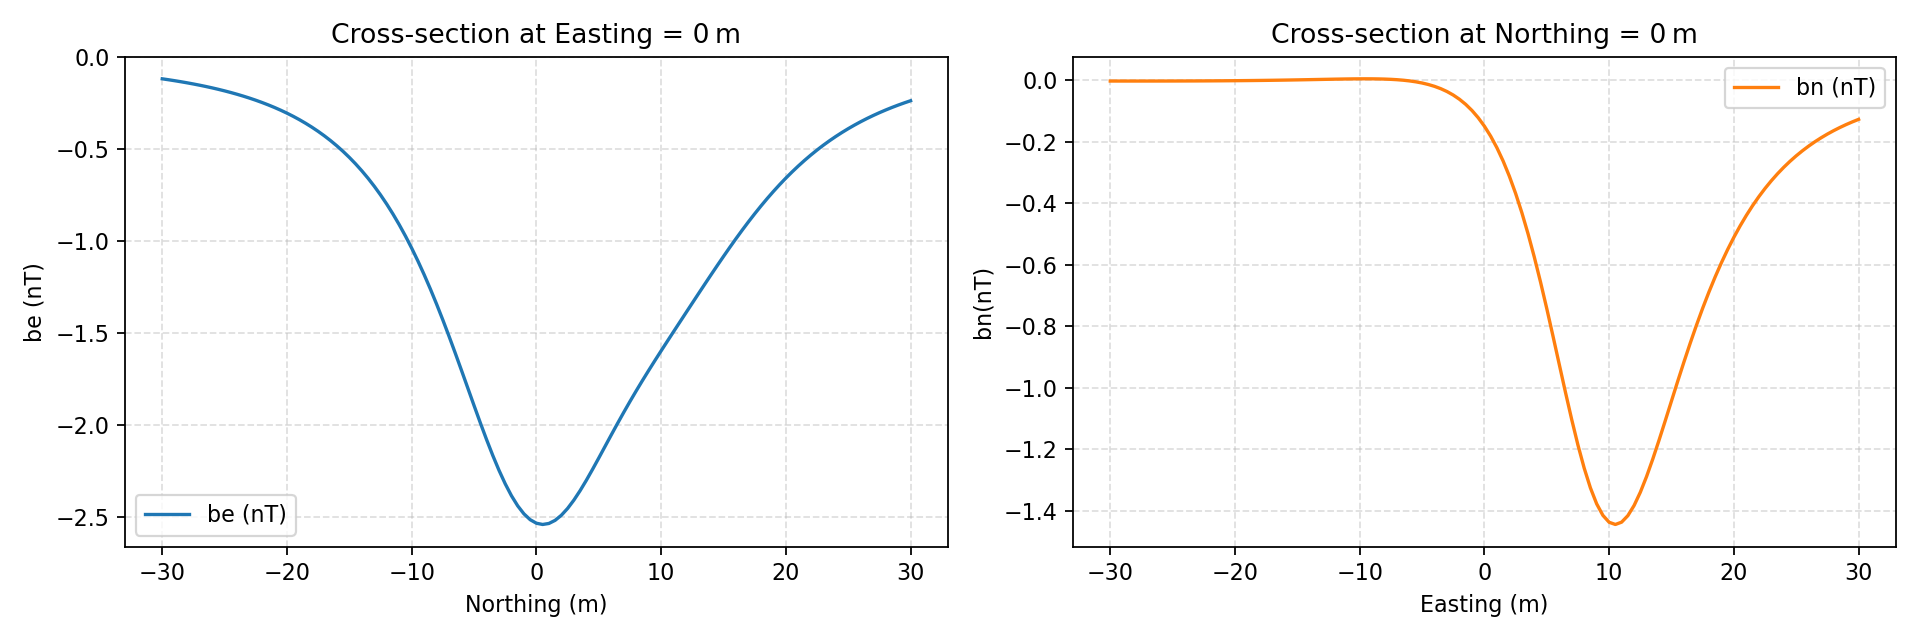

In [9]:
idx_x0 = np.abs(easting[0]).argmin()       
north_line = northing[:, idx_x0]           
be_line    = be[:, idx_x0]                 

idx_y0 = np.abs(northing[:, 0]).argmin()   
east_line  = easting[idx_y0, :]            
bn_line    = bn[idx_y0, :]                 


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=False)

ax1.plot(north_line, be_line, label="be (nT)")
ax1.set_title("Cross‑section at Easting = 0 m")
ax1.set_xlabel("Northing (m)")
ax1.set_ylabel("be (nT)")
ax1.grid(True, linestyle="--", alpha=0.4)
ax1.legend()

ax2.plot(east_line, bn_line, label="bn (nT)", color="tab:orange")
ax2.set_title("Cross‑section at Northing = 0 m")
ax2.set_xlabel("Easting (m)")
ax2.set_ylabel("bn(nT)")
ax2.grid(True, linestyle="--", alpha=0.4)
ax2.legend()

plt.tight_layout()
plt.show()

### Colourmaps of gravity components - simple example

In [10]:
ge, gn, gu = fnc.ellipsoid_gravity(coordinates, triaxial_example, density=2000)

<IPython.core.display.Javascript object>


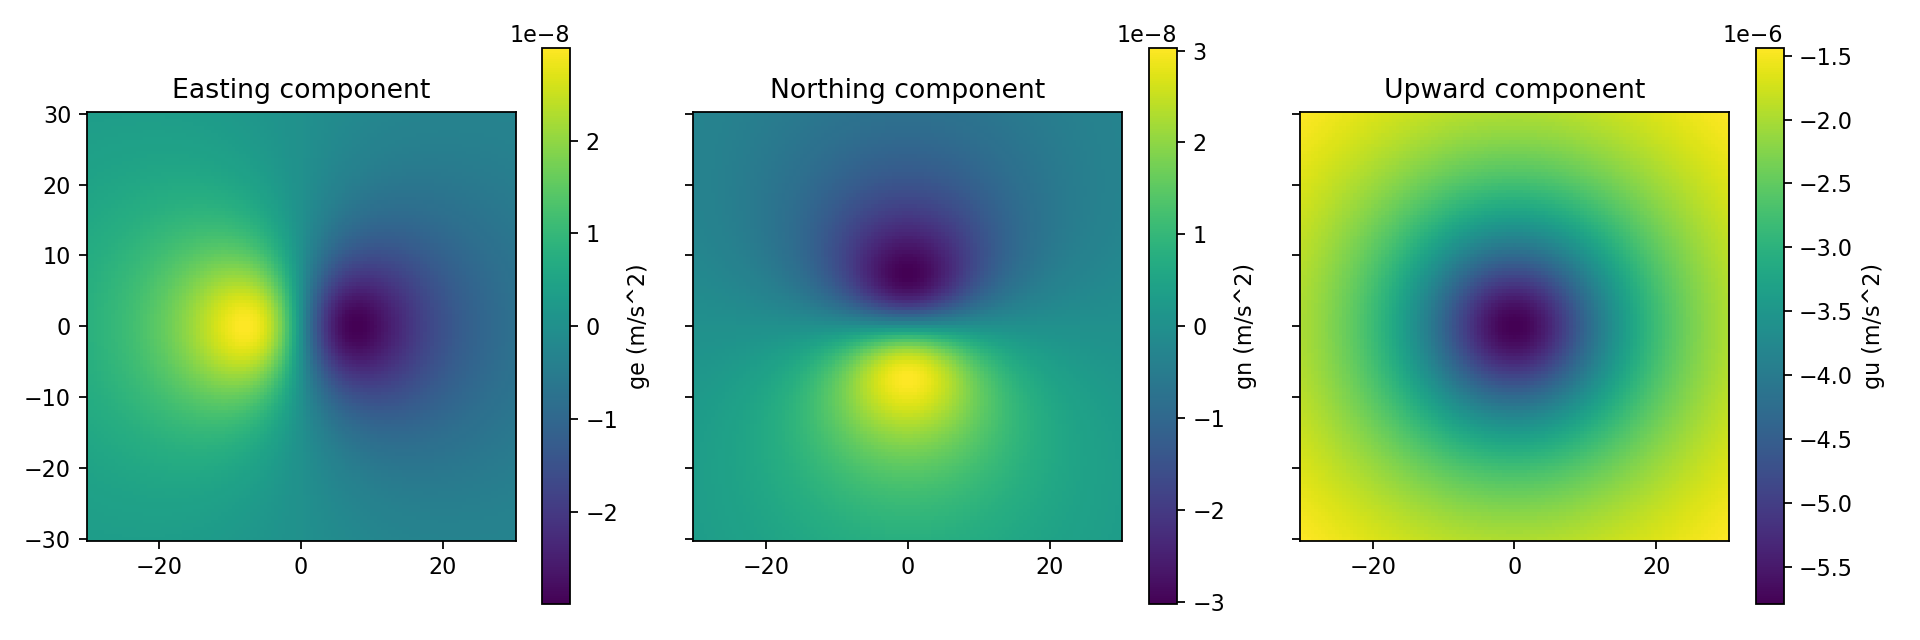

In [11]:
easting, northing = coordinates[:2]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

tmp = ax1.pcolormesh(easting, northing, ge)
ax1.set_title("Easting component")
plt.colorbar(tmp, ax=ax1, label="ge (m/s^2)")

tmp = ax2.pcolormesh(easting, northing, gn)
ax2.set_title("Northing component")
plt.colorbar(tmp, ax=ax2, label="gn (m/s^2)")

tmp = ax3.pcolormesh(easting, northing, gu)
ax3.set_title("Upward component")
plt.colorbar(tmp, ax=ax3, label="gu (m/s^2)")

for ax in (ax1, ax2, ax3):
    ax.set_aspect("equal")

    
plt.tight_layout()
plt.show()

### 1D cross section

<IPython.core.display.Javascript object>


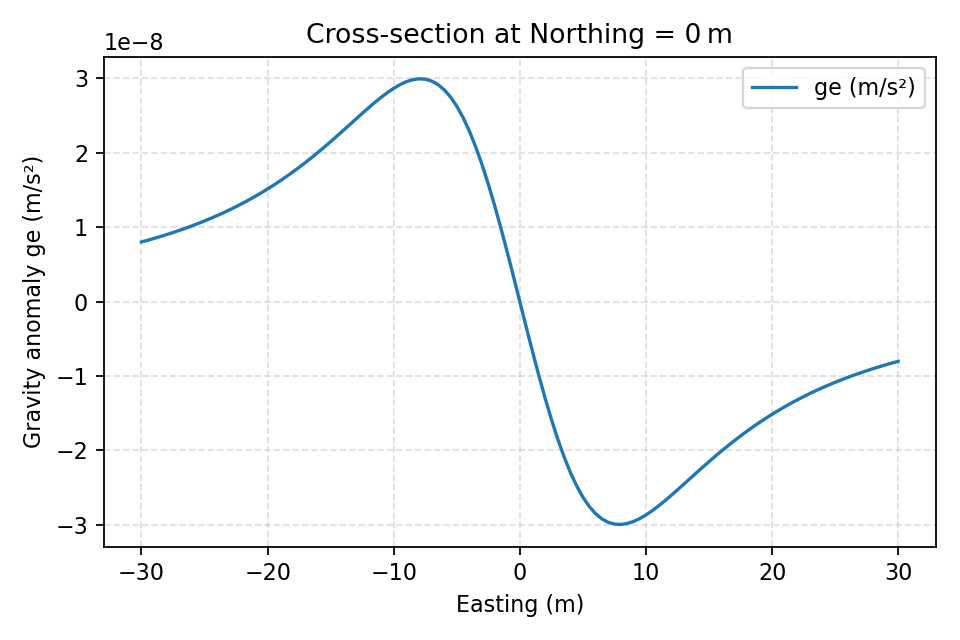

In [12]:
idx_y0 = np.abs(northing[:, 0]).argmin()   

east_line = easting[idx_y0, :]             
ge_line   = ge[idx_y0, :]                  

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(east_line, ge_line, label="ge (m/s²)")

ax.set_title("Cross‑section at Northing = 0 m")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Gravity anomaly ge (m/s²)")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()

### Colourmaps of gravity components - complex example

In [13]:
ge, gn, gu = fnc.ellipsoid_gravity(coordinates, [triaxial_example2, triaxial_example], density=[2000, 4000])

<IPython.core.display.Javascript object>


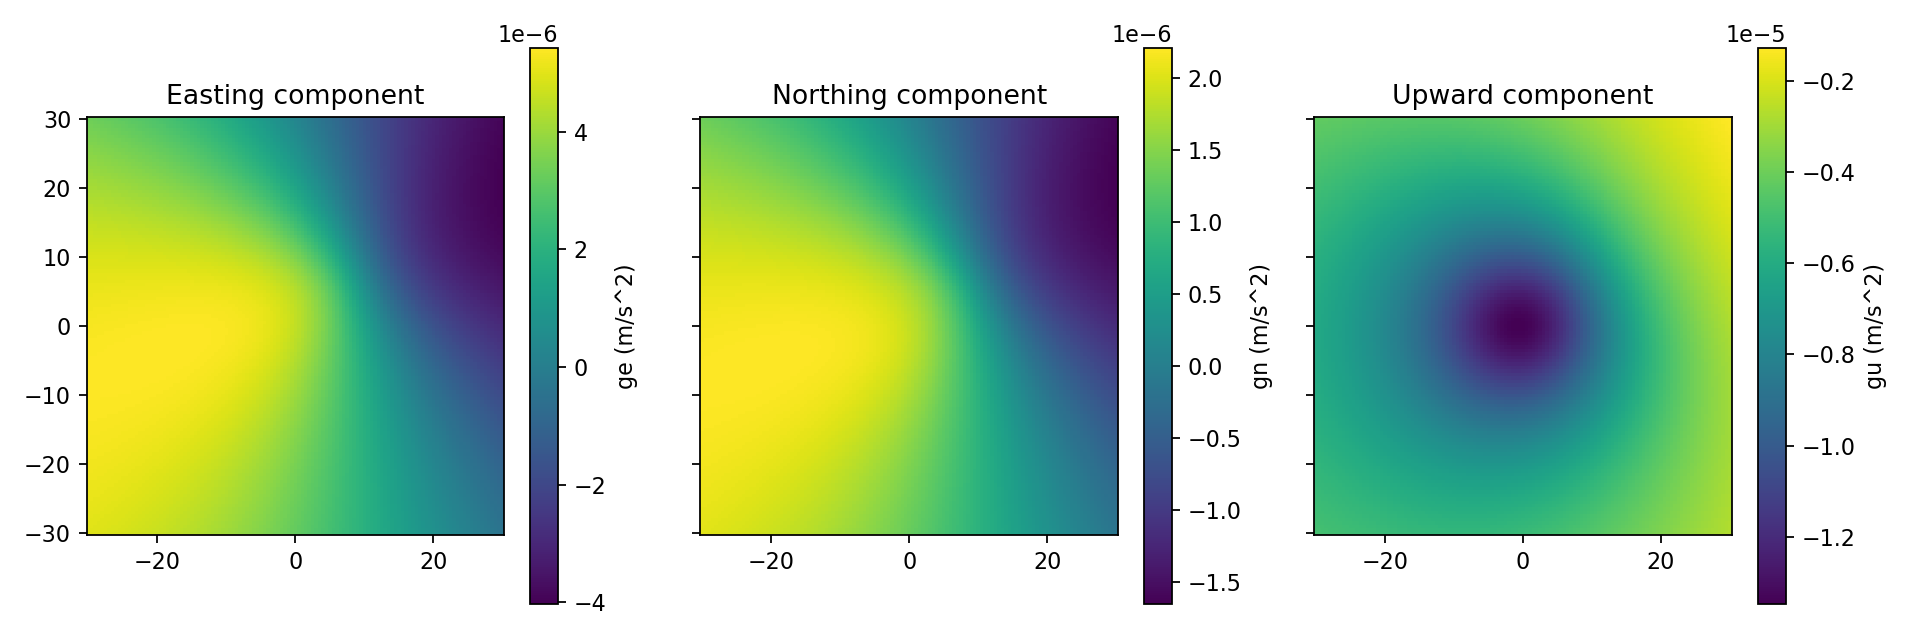

In [14]:
easting, northing = coordinates[:2]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

tmp = ax1.pcolormesh(easting, northing, ge)
ax1.set_title("Easting component")
plt.colorbar(tmp, ax=ax1, label="ge (m/s^2)")

tmp = ax2.pcolormesh(easting, northing, gn)
ax2.set_title("Northing component")
plt.colorbar(tmp, ax=ax2, label="gn (m/s^2)")

tmp = ax3.pcolormesh(easting, northing, gu)
ax3.set_title("Upward component")
plt.colorbar(tmp, ax=ax3, label="gu (m/s^2)")

for ax in (ax1, ax2, ax3):
    ax.set_aspect("equal")

    
plt.tight_layout()
plt.show()

## 1D example

Cross section of multi-ellipsoid example:

<IPython.core.display.Javascript object>


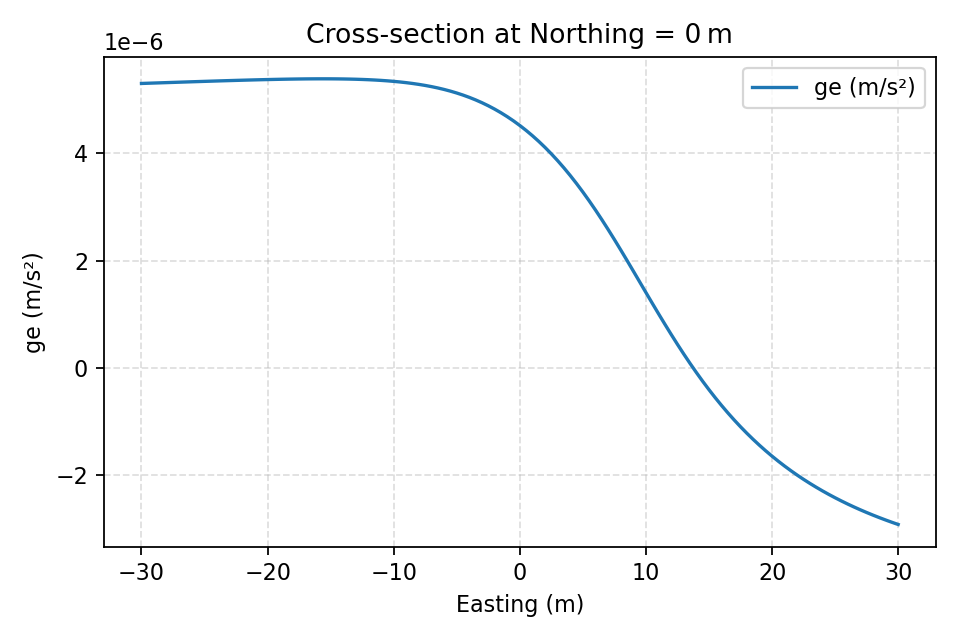

In [15]:
idx_y0 = np.abs(northing[:, 0]).argmin()   

east_line = easting[idx_y0, :]             
ge_line   = ge[idx_y0, :]                  

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(east_line, ge_line, label="ge (m/s²)")

ax.set_title("Cross‑section at Northing = 0 m")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("ge (m/s²)")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()

### Gravity decay comparison of ellipsoid body and point mass

In [43]:
 # plot decay when moving along the z-axis

z = np.linspace(5, 10*5**2, 50)
x = y = np.zeros_like(z)

# lists to hold variables
gz = []
point_gz = []
density = 2000
# calculate ellipsoid mass
ellipsoid_mass =  density * 4/3 * np.pi * 5**3


In [44]:
# create a near spherical ellipsoid
triaxial_example3 = fnc.TriaxialEllipsoid(a=5, b = 4.99, c = 4.98, yaw = 0, pitch = 0, roll = 0,  centre = (0, 0, 0))

_, _, gu = fnc.ellipsoid_gravity((x, y, z), triaxial_example3, density=density)

In [45]:
for i in range(len(x)):
        point_grav = pointgrav(x[i], y[i], z[i], 0, 0, 0, ellipsoid_mass)
        point_gz.append(point_grav)


In [50]:
print(gu)
print(point_gz)

[-0.00416994 -0.00417822 -0.00417977 -0.00418031 -0.00418056 -0.00418069
 -0.00418077 -0.00418083 -0.00418086 -0.00418089 -0.00418091 -0.00418092
 -0.00418094 -0.00418094 -0.00418095 -0.00418096 -0.00418096 -0.00418097
 -0.00418097 -0.00418097 -0.00418098 -0.00418098 -0.00418098 -0.00418098
 -0.00418098 -0.00418098 -0.00418099 -0.00418099 -0.00418099 -0.00418099
 -0.00418099 -0.00418099 -0.00418099 -0.00418099 -0.00418099 -0.00418099
 -0.00418099 -0.00418099 -0.00418099 -0.00418099 -0.00418099 -0.004181
 -0.004181   -0.004181   -0.004181   -0.004181   -0.004181   -0.004181
 -0.004181   -0.004181  ]
[-2.7957242463805806e-06, -6.989310615951452e-07, -3.1063602737562006e-07, -1.747327653987863e-07, -1.1182896985522323e-07, -7.765900684390502e-08, -5.705559686490981e-08, -4.368319134969657e-08, -3.451511415284668e-08, -2.795724246380581e-08, -2.3105159060996535e-08, -1.9414751710976254e-08, -1.6542747020003437e-08, -1.4263899216227453e-08, -1.2425441095024803e-08, -1.0920797837424143e-08, 

<IPython.core.display.Javascript object>


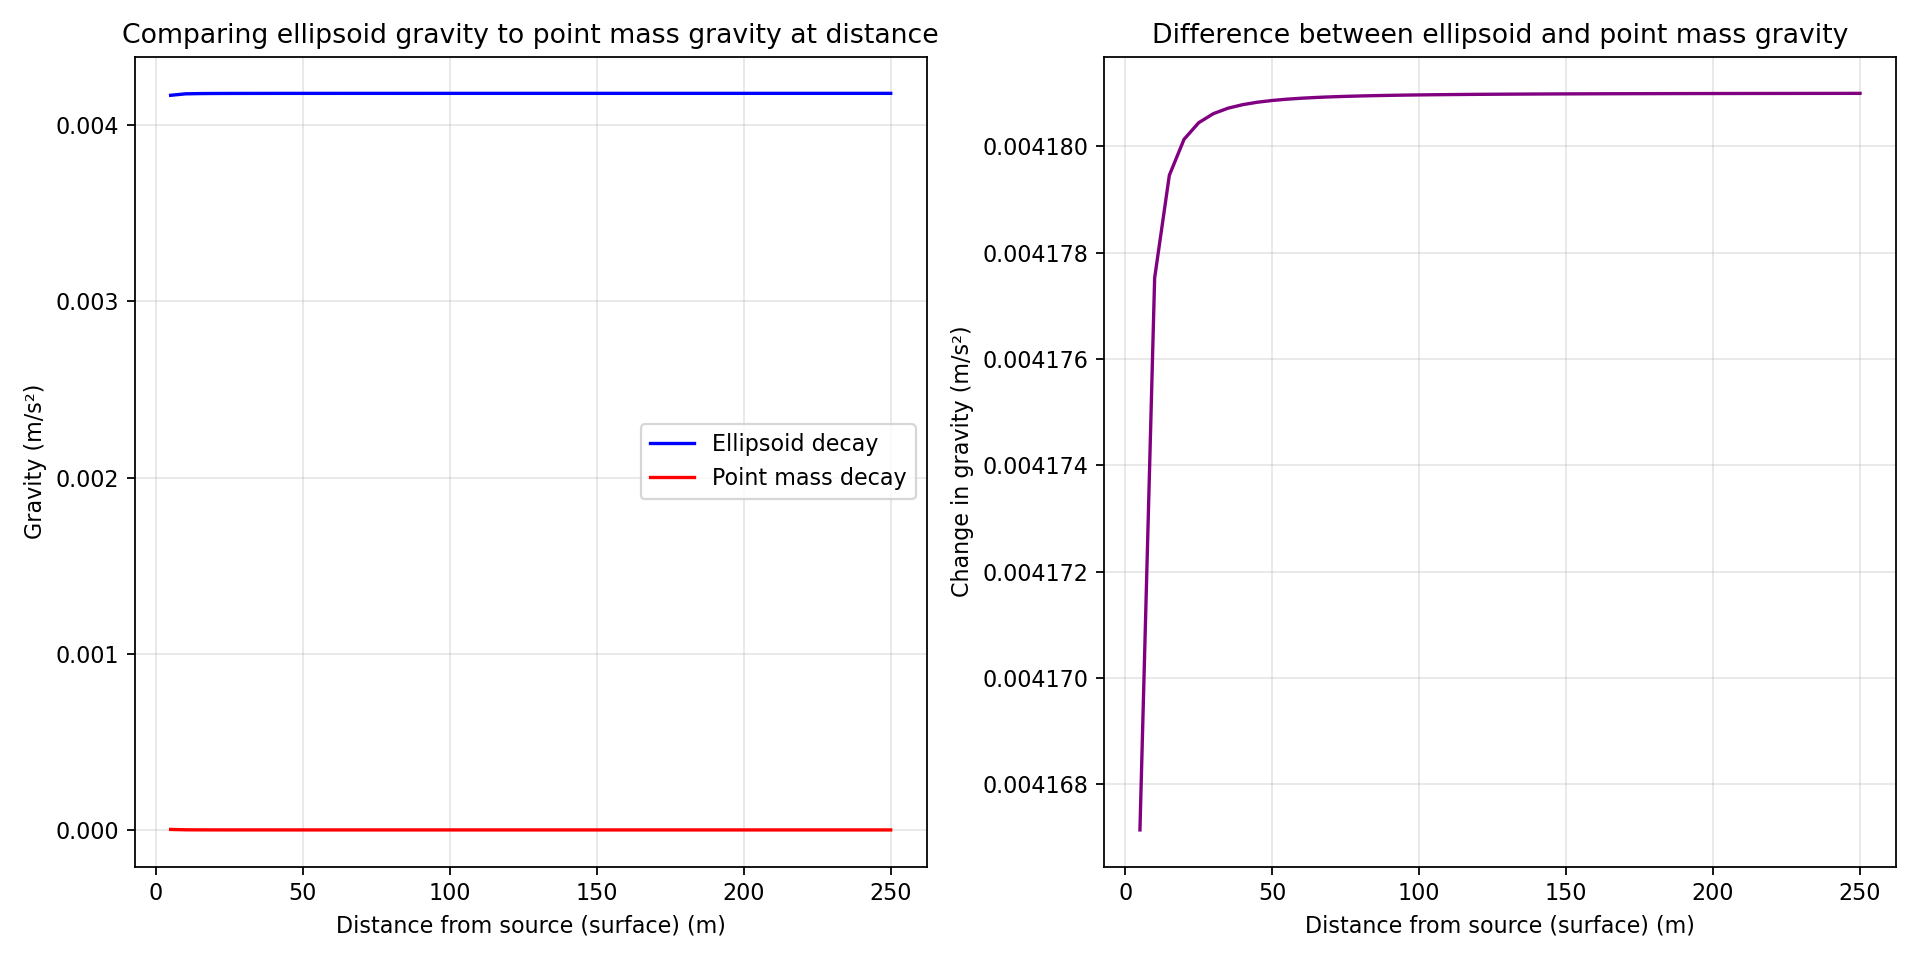

In [47]:
# plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# plot 1: gravity decay of the two models
axs[0].set_title("Comparing ellipsoid gravity to point mass gravity at distance")
axs[0].plot(z, np.abs(gu), color='blue', label='Ellipsoid decay')
axs[0].plot(z, np.abs(point_gz), color='red', label='Point mass decay')
axs[0].set_ylabel('Gravity (m/s²)')
axs[0].set_xlabel('Distance from source (surface) (m)')
axs[0].legend()
axs[0].grid(alpha=0.3)

# plot 2: difference between the gravity models
axs[1].set_title("Difference between ellipsoid and point mass gravity")
axs[1].plot(z, np.abs(gu) - np.abs(point_gz), color='purple', label='Difference')
axs[1].set_xlabel('Distance from source (surface) (m)')
axs[1].set_ylabel('Change in gravity (m/s²)')
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Comparison of magnetic field for near-spheriod ellipsoids with dipole-sphere approximation

In [ ]:

k = 1
b0 = np.array(hm.magnetic_angles_to_vec(55_000, 0.0, 90.0))  
H0_Am = b0 * 1e-9 / mu_0
M = k * H0_Am
# Define ellipsoid (make it nearly a sphere)
# ------------------------------------------

pro_ellipsoid = ProlateEllipsoid(a=60, b=59.99, yaw=0, pitch=0, centre=(0, 0, 0))
tri_ellipsoid = fnc.TriaxialEllipsoid(a=60, b=59.999, c=59.998, yaw = 0, pitch=0, roll=0, centre=(0, 0, 0))
obl_ellipsoid = fnc.OblateEllipsoid(a=59.99, b=60, yaw = 0, pitch=0, centre=(0, 0, 0))

# Define observation points along easting
# ---------------------------------------
easting = np.linspace(0, 2 * 60, 501)
northing, upward = np.zeros_like(easting), np.zeros_like(easting)
coordinates = tuple(np.atleast_2d(c) for c in (easting, northing, upward))

# Compute magnetic field for ellipsoid
# ------------------------------------
be, bn, bu = ellipsoid_magnetics(coordinates, pro_ellipsoid, k, (55_000, 0.0, 90.0), field="b")
be = be.ravel()

be1, bn1, bu1 = ellipsoid_magnetics(coordinates, tri_ellipsoid, k, (55_000, 0.0, 90.0), field="b")
be1 = be1.ravel()
#
be2, bn2, bu2 = ellipsoid_magnetics(coordinates, obl_ellipsoid, k, (55_000, 0.0, 90.0), field="b")
be2 = be2.ravel()

# Compute magnetic field for a sphere (analytic)
# ----------------------------------------------  
b_e, b_n, b_u = fnc._sphere_magnetic(coordinates, radius=60, center=(0, 0, 0), magnetization= M)
b_e = b_e.ravel()

# Plot comparison
# ---------------
plt.figure(figsize=(10, 6))
#plt.plot(easting, be, label="Pro Ellipsoid")
plt.plot(easting, be1, label="Triaxial Ellipsoid")
#plt.plot(easting, be2, label="Obl Ellipsoid")

plt.plot(easting, b_e, '--', label="Dipole-modelled Sphere", alpha=0.7)
plt.xlabel("Easting [m]")
plt.ylabel("|ΔBe| [nT]")
plt.legend()
plt.title("Magnetic field comparison: Ellipsoid vs Sphere")
plt.grid(True)
plt.show()
#print('Prolate internal = ', be[0]) 
#print('Oblate internal = ', be2[0]) 
#print('Triaxial internal = ', be1[0])
#print('True sphere = ', b_e[0])
print(M)